In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
# CTR Baseline Notebook
# Logistic Regression on small Criteo subset
import src0215.data as data 
import src0215.features as features
import src0215.train as train
import src0215.evaluate as evaluate 
from sklearn.metrics import roc_auc_score, log_loss
import importlib

#Reload all the modules to make sure the changes to the dependency files are always live.
importlib.reload(data)
importlib.reload(features)
importlib.reload(train)
importlib.reload(evaluate)

# Replace with your local path to Criteo dataset
num_features, cat_features, columns, X_train, X_val, X_train_raw, X_val_raw, y_train, y_val = (
    data.load_data(
        data_path = "../data/criteo/train.txt",
        data_size = 100*1000
    )
)
# print("\n数据详情：")
# X_train.info()
# y_train.info()
# X_val.info()
# y_val.info()

X_train_final, X_val_final = features.process_features(
    X_train, X_val, num_features, cat_features
)
# shape1 = X_train_final.shape
# shape2 = X_val_final.shape
# print(f"train 数据详情：{shape1}")
# print(f"val 数据详情：{shape2}")

model = train.train_model(X_train_final, y_train)
y_val_pred = evaluate.model_predict(model, X_val_final)

print("Improved SGD/Logistic Regression AUC:", roc_auc_score(y_val, y_val_pred))
print("Improved SGD/Logistic Regression LogLoss:", log_loss(y_val, y_val_pred))

Improved SGD/Logistic Regression AUC: 0.7708286216847612
Improved SGD/Logistic Regression LogLoss: 0.45363924496489155


# Plot Calibration Curve

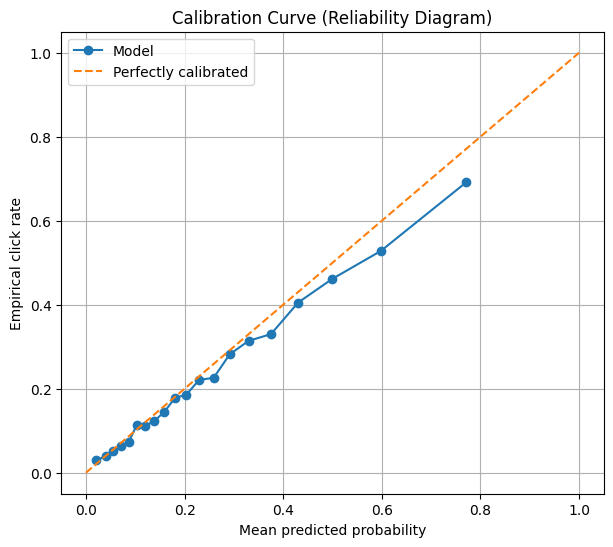

AUC     : 0.7708286216847612
LogLoss : 0.45363924496489155
Brier   : 0.14614226791274243
Pred mean (avg p): 0.24810948444515893
True mean (CTR)  : 0.22865


In [133]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score

# 1) Get validation probabilities on validation set
y_pred = model.predict_proba(X_val_final)[:, 1]

# 2) Compute calibration curve (reliability diagram)
# n_bins: try 10, 20, or 30. strategy="quantile" gives equal points per bin.
prob_true, prob_pred = calibration_curve(
    y_val, y_pred,
    n_bins=20,
    strategy="quantile"
)

# 3) Plot
plt.figure(figsize=(7, 6))
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical click rate")
plt.title("Calibration Curve (Reliability Diagram)")
plt.grid(True)
plt.legend()
plt.show()

# 4) Print complementary metrics (helpful for diagnosis)
print("AUC     :", roc_auc_score(y_val, y_pred))
print("LogLoss :", log_loss(y_val, y_pred))
print("Brier   :", brier_score_loss(y_val, y_pred))
print("Pred mean (avg p):", float(np.mean(y_pred)))
print("True mean (CTR)  :", float(np.mean(y_val)))

# Add platt scaling calibration layer

In [134]:
import numpy as np

# Base model probabilities
p_val = model.predict_proba(X_val_final)[:, 1]

# Numerical safety
eps = 1e-15
p_val = np.clip(p_val, eps, 1 - eps)

# Convert to logits
logits_val = np.log(p_val / (1 - p_val)).reshape(-1, 1)

In [135]:
from sklearn.linear_model import LogisticRegression

platt = LogisticRegression(
    penalty=None,      # IMPORTANT: no regularization
    solver="lbfgs",
    max_iter=1000
)

platt.fit(logits_val, y_val)

LogisticRegression(max_iter=1000, penalty=None)

In [136]:
# Calibrated probabilities
p_val_cal = platt.predict_proba(logits_val)[:, 1]

In [137]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

print("=== BEFORE calibration ===")
print("AUC     :", roc_auc_score(y_val, p_val))
print("LogLoss :", log_loss(y_val, p_val))
print("Brier   :", brier_score_loss(y_val, p_val))
print("Mean p  :", float(np.mean(p_val)))
print("True CTR:", float(np.mean(y_val)))

print("\n=== AFTER Platt scaling ===")
print("AUC     :", roc_auc_score(y_val, p_val_cal))  # should be identical
print("LogLoss :", log_loss(y_val, p_val_cal))       # should improve
print("Brier   :", brier_score_loss(y_val, p_val_cal))
print("Mean p  :", float(np.mean(p_val_cal)))


=== BEFORE calibration ===
AUC     : 0.7708286216847612
LogLoss : 0.45363924496489155
Brier   : 0.14614226791274243
Mean p  : 0.24810948444515893
True CTR: 0.22865

=== AFTER Platt scaling ===
AUC     : 0.7708286216847612
LogLoss : 0.45158464212189847
Brier   : 0.1454130510237961
Mean p  : 0.22864960844746166


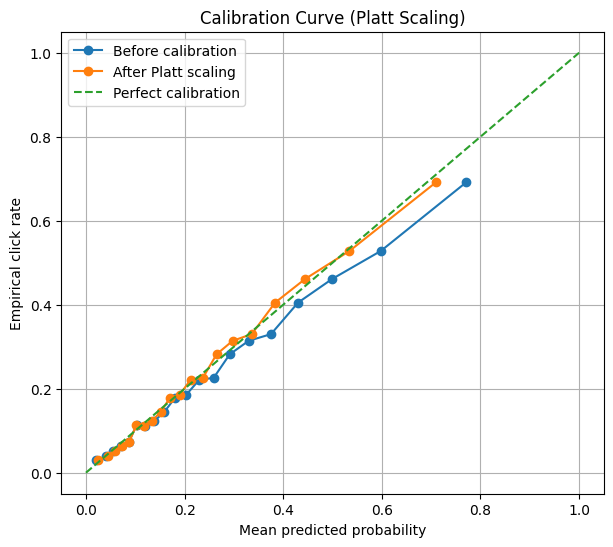

In [138]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true_b, prob_pred_b = calibration_curve(
    y_val, p_val, n_bins=20, strategy="quantile"
)
prob_true_a, prob_pred_a = calibration_curve(
    y_val, p_val_cal, n_bins=20, strategy="quantile"
)

plt.figure(figsize=(7,6))
plt.plot(prob_pred_b, prob_true_b, marker="o", label="Before calibration")
plt.plot(prob_pred_a, prob_true_a, marker="o", label="After Platt scaling")
plt.plot([0,1], [0,1], "--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Empirical click rate")
plt.title("Calibration Curve (Platt Scaling)")
plt.grid(True)
plt.legend()
plt.show()


In [139]:
import pandas as pd
import numpy as np

val_df = X_val_raw.copy()
val_df["y"] = y_val.values
#val_df["p"] = p_val
val_df["p"] = p_val_cal

# 10 quantile bins
val_df["pred_bin"] = pd.qcut(val_df["p"], q=10, duplicates="drop")

seg_pred = val_df.groupby("pred_bin").agg(
    n=("y", "size"),
    ctr=("y", "mean"),
    mean_p=("p", "mean")
)
seg_pred["bias"] = seg_pred["mean_p"] - seg_pred["ctr"]
seg_pred


/var/folders/ct/sr0q4fwd5n520wg32tl97k1m0000gn/T/ipykernel_9015/3723302744.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_pred = val_df.groupby("pred_bin").agg(


,n,ctr,mean_p,bias
pred_bin,,,,
"(-0.0009999999999755, 0.0509]",2000,0.0345,0.033968,-0.000532
"(0.0509, 0.0801]",2000,0.0575,0.065742,0.008242
"(0.0801, 0.11]",2000,0.0930,0.094871,0.001871
"(0.11, 0.143]",2000,0.1175,0.125899,0.008399
"(0.143, 0.18]",2000,0.1615,0.160901,-0.000599
"(0.18, 0.224]",2000,0.2035,0.201100,-0.002400
"(0.224, 0.28]",2000,0.2540,0.251051,-0.002949
"(0.28, 0.358]",2000,0.3220,0.316808,-0.005192
"(0.358, 0.482]",2000,0.4330,0.413789,-0.019211


In [140]:
cat_cali_col = "C1"  # try C1, C2, C14, C20

freq_map = X_train_raw[cat_cali_col].astype(str).value_counts()

In [141]:
val_df = val_df.copy()
val_df["cat_freq"] = X_val_raw[cat_cali_col].astype(str).map(freq_map).fillna(0)

bins = [-1, 0, 1, 5, 20, 100, 1e9]
labels = ["unseen", "1", "2–5", "6–20", "21–100", "100+"]

val_df["freq_bucket"] = pd.cut(val_df["cat_freq"], bins=bins, labels=labels)

seg_freq = val_df.groupby("freq_bucket").agg(
    n=("y", "size"),
    ctr=("y", "mean"),
    mean_p=("p", "mean")
)
seg_freq["bias"] = seg_freq["mean_p"] - seg_freq["ctr"]
seg_freq


/var/folders/ct/sr0q4fwd5n520wg32tl97k1m0000gn/T/ipykernel_9015/1715250413.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_freq = val_df.groupby("freq_bucket").agg(


,n,ctr,mean_p,bias
freq_bucket,,,,
unseen,71,0.169014,0.219668,0.050654
1,33,0.242424,0.199813,-0.042611
2–5,57,0.157895,0.208223,0.050328
6–20,168,0.214286,0.213523,-0.000762
21–100,375,0.234667,0.237468,0.002801
100+,19296,0.229063,0.228753,-0.000310


In [142]:
cali_num_col = "I1"

val_df = val_df.copy()
val_df[cali_num_col] = X_val_raw[cali_num_col].fillna(0)

val_df["num_bin"] = pd.qcut(val_df[cali_num_col], q=10, duplicates="drop")

seg_num = val_df.groupby("num_bin").agg(
    n=("y", "size"),
    ctr=("y", "mean"),
    mean_p=("p", "mean")
)
seg_num["bias"] = seg_num["mean_p"] - seg_num["ctr"]
seg_num


/var/folders/ct/sr0q4fwd5n520wg32tl97k1m0000gn/T/ipykernel_9015/1738165186.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_num = val_df.groupby("num_bin").agg(


,n,ctr,mean_p,bias
num_bin,,,,
"(-0.001, 1.0]",15512,0.184567,0.191990,0.007423
"(1.0, 2.0]",1017,0.330383,0.314932,-0.015451
"(2.0, 5.0]",1521,0.360289,0.338415,-0.021874
"(5.0, 326.0]",1950,0.423590,0.389656,-0.033934


In [143]:
cat_cols = [f"C{i}" for i in range(1, 27)]

val_df = val_df.copy()
val_df["num_missing_cat"] = X_val_raw[cat_cols].isna().sum(axis=1)

val_df["missing_bin"] = pd.qcut(
    val_df["num_missing_cat"], q=5, duplicates="drop"
)

seg_sparse = val_df.groupby("missing_bin").agg(
    n=("y", "size"),
    ctr=("y", "mean"),
    mean_p=("p", "mean")
)
seg_sparse["bias"] = seg_sparse["mean_p"] - seg_sparse["ctr"]
seg_sparse
#val_df[["num_bin", "num_missing_cat", "missing_bin", "y", "p"]].head(20)


/var/folders/ct/sr0q4fwd5n520wg32tl97k1m0000gn/T/ipykernel_9015/2195917530.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg_sparse = val_df.groupby("missing_bin").agg(


,n,ctr,mean_p,bias
missing_bin,,,,
"(-0.001, 1.0]",9334,0.230126,0.227219,-0.002907
"(1.0, 4.0]",3602,0.245142,0.241599,-0.003543
"(4.0, 5.0]",5762,0.209823,0.214775,0.004953
"(5.0, 12.0]",1302,0.255760,0.264482,0.008721


In [144]:
from sklearn.isotonic import IsotonicRegression
import numpy as np

iso = IsotonicRegression(out_of_bounds="clip")

p_val = model.predict_proba(X_val_final)[:, 1]

# Fit on validation only (no leakage!)
iso.fit(p_val, y_val)

# Calibrated probabilities
p_val_iso = iso.transform(p_val)


In [145]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

print("AUC     :", roc_auc_score(y_val, p_val))
print("Log     :", log_loss(y_val, p_val))
print("Brier   :", brier_score_loss(y_val, p_val))

print("AUC after Iso Regression     :", roc_auc_score(y_val, p_val_iso))
print("LogLoss after Iso Regression :", log_loss(y_val, p_val_iso))
print("Brier after Iso Regression   :", brier_score_loss(y_val, p_val_iso))

AUC     : 0.7708286216847612
Log     : 0.45363924496489155
Brier   : 0.14614226791274243
AUC after Iso Regression     : 0.772324631382941
LogLoss after Iso Regression : 0.4489200412118721
Brier after Iso Regression   : 0.14468685167511317


In [146]:
import pandas as pd
import numpy as np

n_buckets = 5

cal_df = pd.DataFrame({
    "p": p_val,
    "y": y_val
})

cal_df["bucket"] = pd.qcut(
    cal_df["p"],
    q=n_buckets,
    duplicates="drop"
)


In [147]:
from sklearn.linear_model import LogisticRegression

bucket_models = {}

eps = 1e-15

for b, g in cal_df.groupby("bucket"):
    if len(g) < 500:   # safety: skip tiny buckets
        continue

    p = np.clip(g["p"].values, eps, 1 - eps)
    logits = np.log(p / (1 - p)).reshape(-1, 1)

    lr = LogisticRegression(
        solver="lbfgs",
        max_iter=1000
    )
    lr.fit(logits, g["y"].values)

    bucket_models[b] = lr


/var/folders/ct/sr0q4fwd5n520wg32tl97k1m0000gn/T/ipykernel_9015/2167983029.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for b, g in cal_df.groupby("bucket"):


In [148]:
def apply_bucket_platt(p, buckets, bucket_models):
    eps = 1e-15
    p = np.clip(p, eps, 1 - eps)

    out = np.zeros_like(p)

    for b in np.unique(buckets):
        mask = buckets == b
        if b in bucket_models:
            logits = np.log(p[mask] / (1 - p[mask])).reshape(-1, 1)
            out[mask] = bucket_models[b].predict_proba(logits)[:, 1]
        else:
            # fallback: no calibration for tiny buckets
            out[mask] = p[mask]

    return out


In [149]:
# IMPORTANT: use calibration bins, not recomputed bins
bin_edges = cal_df["bucket"].cat.categories

eval_buckets = pd.cut(
    p_val,
    bins=[c.left for c in bin_edges] + [bin_edges[-1].right],
    include_lowest=True
)

p_val_cal = apply_bucket_platt(p_val, eval_buckets, bucket_models)


In [150]:
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss

print("AUC     :", roc_auc_score(y_val, p_val))
print("LogLoss :", log_loss(y_val, p_val))
print("Brier   :", brier_score_loss(y_val, p_val))

print("AUC after bucketized calibration:     ", roc_auc_score(y_val, p_val_cal))
print("LogLoss after bucketized calibration: ", log_loss(y_val, p_val_cal))
print("Brier after bucketized calibration:   ", brier_score_loss(y_val, p_val_cal))


AUC     : 0.7708286216847612
LogLoss : 0.45363924496489155
Brier   : 0.14614226791274243
AUC after bucketized calibration:      0.7708084934511871
LogLoss after bucketized calibration:  0.4511848163214607
Brier after bucketized calibration:    0.1453422650507178


In [ ]:
# Without class weighting
AUC after bucketized calibration:      0.7708084934511871
LogLoss after bucketized calibration:  0.4511848163214607
Brier after bucketized calibration:    0.1453422650507178